### Portafolio Óptimo
Hoy iniciaremos nuestro "viaje" en las finanzas cuantitativas obteniendo el Portafolio Óptimo de Markowitz. Este funciona maximizando el ratio del mismo nombre. Este trata sobre la relación entre retorno y riesgo. Intuitivamente queremos obtener el mayor retorno al menor riesgo posible.

Para mi aprendizaje fueron utilizados los sitios:
- Quantopian: https://blog.quantopian.com/markowitz-portfolio-optimization-2/
- Medium: https://medium.com/python-data/efficient-frontier-portfolio-optimization-with-python-part-2-2-2fe23413ad94

La diferencia en los códigos de los sitios mencionados y el mío son que el primero utiliza muchas funciones para llegar al portafolio óptimo y el segundo no ocupa ninguna, sólo un for loop.

Mi aporte fue tomar lo mejor de ambos caminos y armar con ello una sola función que haga todo el trabajo con sólo mencionarla y "alimentarla" con los retornos de los activos a analizar. Lo anterior, con el objetivo de maximizar mi aprendizaje aprendiendo a programar la función para encontrar el portafolio óptimo incorporando cambios origanales y que al mismo me facilitan la lectura del código debido a que es propio.

In [0]:
#Importamos las Librerías necesarias

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np
from datetime import datetime
start = datetime(2010,1,4)
import pandas_datareader.data as web

#### Obtenemos Data Financiera
Existen librerías muy utiles, pandas_datareader nos permite obtener datos financieros de múltiples fuentes confiables, entre ellas: Yahoo Finance y FRED

In [34]:
#Market Data
market_data = web.get_data_yahoo(["^GSPC", "^GDAXI", "^FCHI",  "^N225", "^HSI", "^BVSP", "^MXX"], start)
market_data = market_data["Close"].fillna(method="ffill")
activos = ["^GSPC", "^GDAXI", "^FCHI",  "^N225", "^HSI", "^BVSP", "^MXX"] 
market_data.tail(3)

Symbols,^BVSP,^FCHI,^GDAXI,^GSPC,^HSI,^MXX,^N225
Date,,,,,,,
2019-02-01,97861.000000,5019.259766,11180.660156,2706.530029,27930.740234,43738.269531,20788.390625
2019-02-04,98589.000000,5000.189941,11176.580078,2724.870117,27990.210938,43738.269531,20883.769531
2019-02-05,98311.210938,5083.339844,11367.980469,2737.699951,27990.210938,44337.101562,20844.449219


Tasas soberanas de Estados Unidos

In [35]:
#Risk Free
US_rates = web.get_data_fred(["DTB3", "DGS3MO", "DTB6", "DGS6MO", "DTB1YR", "DGS2", "DGS10"], start)
US_rates = US_rates.fillna(method="ffill")
US_rates.tail(3)

#Observación: Esta tabla nos muestra la tasa (el anterior nos muestra el valor del índice) por tanto los tratamientos varían

,DTB3,DGS3MO,DTB6,DGS6MO,DTB1YR,DGS2,DGS10
DATE,,,,,,,
2019-01-31,2.36,2.41,2.40,2.46,2.47,2.45,2.63
2019-02-01,2.35,2.40,2.40,2.46,2.48,2.52,2.70
2019-02-04,2.37,2.42,2.43,2.49,2.49,2.53,2.73


####**Calculamos los retornos anuales asociados**
De esta manera podeos calcular los excesos de retornos, fundamentales para obtener "el valor" que crea la combinación óptima por sobre un premio sin riesgo. En otras palabras obtenemos el **Premio por Riesgo**

In [0]:
retornos = market_data.iloc[0:2000,:].pct_change(20).dropna() #obetemos los retornos de los primeros 2000 días
retornos_mercado = market_data.iloc[0:2000,:].pct_change(240).dropna().mean() #obtenemos los retornos promedio anuales [trading days] 
retornos_rf = US_rates.iloc[0:2000,4].mean()/100 #obtenemos retornos de tasa a un año (recordar, estaba expresado en tasa)
retornos_exceso = retornos_mercado-retornos_rf #finalmente sacamos los Premios por Riesgo


retornos1 = market_data.iloc[2000:,:].pct_change(20).dropna() #obetemos los retornos en periodo de testeo
retornos_mercado1 = market_data.iloc[2000:,:].pct_change(240).dropna().mean() #obtenemos los retornos promedio anuales [trading days] 
retornos_rf1 = US_rates.iloc[2000:,4].mean()/100 #obtenemos retornos de tasa a un año (recordar, estaba expresado en tasa)
retornos_exceso1 = retornos_mercado1-retornos_rf1 #finalmente sacamos los Premios por Riesgo

####**Analizamos Correlaciones**

Saber como se correlacionan los activos de nuestro portafolio es muy importante, ya que nos permite rapidamente saber como interactuan de una manera sencilla.

Por ejemplo, saber que el CAC 40 está muy correlacionado con el DAX (0.9) nos da la posibilidad de actuar rápidamente en el rebalanceo del portafolio en caso de un shock a uno de los dos países. Ya que sabremos que ambos se mueven en conjunto y de un manera muy similar. Por tanto, ante un shock a Francia, tambien tendremos que analizar como le pega al índice alemán y en último término a nuestro portafolio.

**El grafico de la derecha nos servirá para entender como cambian las correlaciones a través del tiempo. Sirve al lector para consulta en los análisis que vienen a continuación**

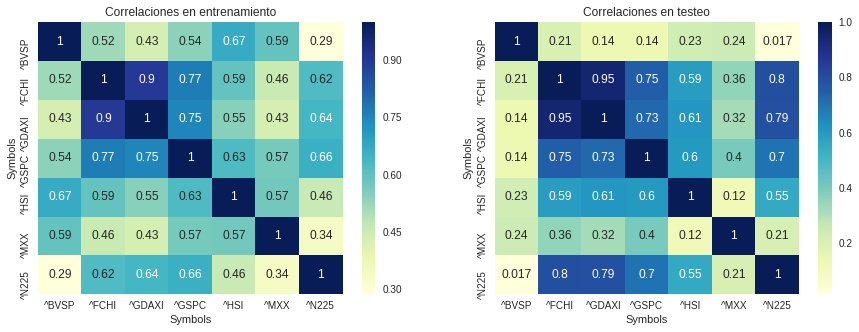

In [37]:
correlaciones = retornos.corr()
fig0 = plt.figure(figsize=(15,5))
ax01 = fig0.add_subplot(1, 2, 1)
sns.heatmap(correlaciones, annot=True, cmap="YlGnBu")
plt.title("Correlaciones en entrenamiento")
ax02 = fig0.add_subplot(1, 2, 2)
sns.heatmap(retornos1.corr(), annot=True, cmap="YlGnBu")
plt.title("Correlaciones en testeo")
plt.subplots_adjust(wspace=0.2, hspace=0.3)




####**Programamos función de retorno óptimo**

Esta fue pensada para que solo fuese necesario llamar a una única función para que sea fácil para cualquier persona utilizar el código. 

Para mayor flexibilidad se dejan fuera de la función la construcción de gráficos y el testeo de pesos alcanzados.

In [0]:
#FUNCIÃN DE PORTAFOLIO ÃPTIMO
def portafolio_optimo(retornos):
    retornos_portafolio = [] #Listas vacÃ­as
    volatilidad_portafolio = [] #Listas vacÃ­as
    sharpe_ratio = [] #Listas vacÃ­as
    pesos_activos = [] #Listas vacÃ­as
    numero_activos = len(activos) #AsÃ­ hago una matriz de pesos
    numero_portafolios = 50000 #NÃºmero de portafolios a simular
    cov = np.cov(retornos) #Covarianza de los retornos
    for portfolio_n in range(numero_portafolios):
        pesos = np.random.random(numero_activos) #Obtengo pesos aleatorios
        pesos /= np.sum(pesos) #Hago que dichos pesos sumen 1
        retorno = np.dot(pesos, retornos) #Retornos de los portafolios simulados
        volatilidad = np.sqrt(np.dot(pesos.T, np.dot(cov, pesos))) #Volatilidad de Portafolios simulados
        #np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
        sharpe = retorno/volatilidad #Sharpe de cada uno
        retornos_portafolio.append(retorno) #Relleno lista de retornos
        volatilidad_portafolio.append(volatilidad) #Relleno lista de volatilidades
        sharpe_ratio.append(sharpe) #Relleno lista de ratios de Sharpe
        pesos_activos.append(pesos) #Relleno lista de pesos aleatorios
    portafolio = {'Retornos': retornos_portafolio, #Diccionario que reÃºne las listas
             'Volatilidad': volatilidad_portafolio,
             'Ratio de Sharpe': sharpe_ratio}
    for contador, activo in enumerate(market_data):
        portafolio[activo+' Peso'] = [Peso[contador] for Peso in pesos_activos]
    global resultados_combinaciones, resultados_max_sharpe, resultados_info_sharpe, resultados_pesos_optimos #Para que sea visbles en exploradpor de variables, las convierto de locales a globales
    
    #Portafolio de Sharpe
    resultados_combinaciones = pd.DataFrame(portafolio) #Universo de Combinaciones, utilizable luego para promediar primeros 100 o 200 //suavizar y no hacer overfit del pasado
    resultados_max_sharpe = resultados_combinaciones["Ratio de Sharpe"].max() #MÃ¡ximo Sharpe
    resultados_info_sharpe = resultados_combinaciones[resultados_combinaciones["Ratio de Sharpe"] == resultados_max_sharpe] #InformaciÃ³n asociada a mÃ¡ximo Sharpe
    resultados_pesos_optimos = resultados_info_sharpe.iloc[:,3:] #Lista de pesos Ã³ptimos

####**La echamos a correr**

In [0]:
portafolio_optimo(retornos_exceso) #OBTENGO PORTAFOLIO OPTIMO


####**Relación retorno/riesgo de todas las combinaciones simuladas. Testeo Portafolio óptimo**

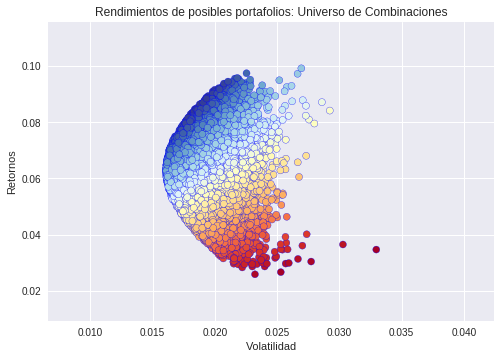

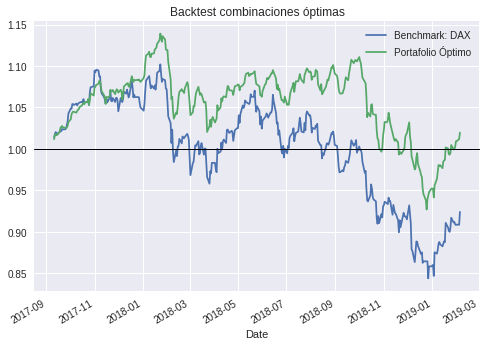

In [29]:
#Universo Ploteado
plt.scatter(x=resultados_combinaciones["Volatilidad"], y=resultados_combinaciones["Retornos"], c=resultados_combinaciones["Ratio de Sharpe"], cmap='RdYlBu',edgecolors="b")
plt.xlabel("Volatilidad")
plt.ylabel("Retornos")
plt.title("Rendimientos de posibles portafolios: Universo de Combinaciones")
plt.show()

#Testeo Portafolio Optimo
global retornos_listado, retornos_diarios_port_sharp, retornos_diarios_port_sharp1, retorno_acumulado_portafolio, benchmark, comparacion
retornos_listado = market_data.iloc[2000:,:].pct_change().dropna() #Le muestro info para poner a prueba combinaciÃ³n selecionada
retornos_listado = retornos_listado.T #reemplazo ceros para no multiplicar por cero mÃ¡s abajo, trasnpongo para hacer multiplicable y obtener resultado diario
retornos_diarios_port_sharp = np.matmul(resultados_pesos_optimos,retornos_listado) #obtengo retornos diarios
retornos_diarios_port_sharp1 = retornos_diarios_port_sharp +1 #a los retornos les sumo 1 (y asÃ­ al multiplicarlos los hago acumulables)
retorno_acumulado_portafolio = (retornos_diarios_port_sharp1).cumprod() #multiplicaciÃ³n acumulada portafolio Ã³ptimo
        
benchmark = ((retornos_listado.iloc[2,:]) +1).cumprod() #multiplicaciÃ³n acumulada benchmark elegido
comparacion = pd.DataFrame(np.column_stack([benchmark, retorno_acumulado_portafolio]), columns=["Benchmark: DAX", "Portafolio Óptimo"], index=benchmark.index) #Hago df con listado de retornos de portafolio y benchmark 
comparacion.plot() #Visualizo la comparaciÃ³n    
plt.axhline(1, color="black", linewidth=1)
plt.title("Backtest combinaciones óptimas")
plt.show()

El primer gráfico nos muestra los rendimientos de cada una de las combinaciones simuladas de portafolios. 

Aquellos de color azul más intenso son los más eficientes. Las combinaciones de color rojo en el gráfico son las menos eficientes. **Intuititvamente queremos aquella que tenga el azul más intenso, ya que este portafolio es el que tiene la combinación más eficiente.**

El segundo gráfico muestra los rendimientos de nuestro portafolio en competencia con el DAX. Vemos que a pesar de ganarle a este índice, la rentabiliad de nuestro portafolio al final del periodo de prueba es **mediocre**. 

Lo anterior se produce porque las condiciones económicas cambiaron a lo largo del año del Backtest. En otras palabras, la información utilizada para conseguir los pesos óptimos (volatilidades, covarianza entre retornos, etc) ya no son utiles ante los nuevos escenarios.  

Por tanto es crucial no solo optimizar el portafolio, tambien es necesario hacer un análisis de coyuntura a lo largo de la vida del portafolio. Así podremos estimar la necesidad de rebalancear el portafolio en base a si se mantienen expectativas ***de que lo que venga hacia adelante sea similar a las condicones con las que optimizamos el portafolio.***



####**Investigamos los detalles del portafolio óptimo**

Observamos que está exageradamente expuesto al S&P500 y al DAX. Esto ocurre porque la "optimización" fue hecha con fuerza bruta. Es decir, simulamos miles de portafolios y elegimos el mejor (Sin establecer restricciones).

La otra opción es usar SciPy, de esta forma vamos directo a la optimización y además, lograremos establecer restricciones en los pesos de manera sencilla.

¿Por qué quisieramos controlar la exposición a un índice si elegiremos un portafolio que no maximzia el ratio de Sharpe? Porque ante shocks como los sufridos por el S&P500 las ganancias de un año pueden literalmente evaporarse. Tal vez el retorno total sufra, sin embargo con menos probabilidad sufriremos pérdidas importantes de acuerdo al criterio del inversionista

In [0]:
resultados_info_sharpe #combinaciones con información pasada

,Ratio de Sharpe,Retornos,Volatilidad,^BVSP Peso,^FCHI Peso,^GDAXI Peso,^GSPC Peso,^HSI Peso,^MXX Peso,^N225 Peso
36993,4.61808,0.088726,0.019213,0.01085,0.096019,0.231288,0.239579,0.035907,0.126036,0.260322


**Los siguientes pesos nos muestran cual habría sido la combinación óptima durante el periodo de testeo. Salvo que tengamos una maquina del tiempo, no podemos saber con anterioridad cual sería la combinación más óptima al momento de implementación.**

In [31]:
portafolio_optimo(retornos_exceso1)
resultados_info_sharpe

,Ratio de Sharpe,Retornos,Volatilidad,^BVSP Peso,^FCHI Peso,^GDAXI Peso,^GSPC Peso,^HSI Peso,^MXX Peso,^N225 Peso
24764,0.477025,0.021211,0.044464,0.40411,0.176381,0.005558,0.35667,0.007711,0.03244,0.017131


####**Distribución Ratios de Sharpe con información de calibración**

A continuación estudiaremos la distribución de los ratios de Sharpe puramente con una intención exploratoria. Lo que podemos ver es que la distribución, si bien tiene un comportamiento normal, está "inclinada" hacia la derecha. 

Esto preeliminarmente puede tener relación con las favorables condiciones económicas implícitas en el periodo de tiempo que utilizamos para optimizar y obtener los pesos más convenientes.

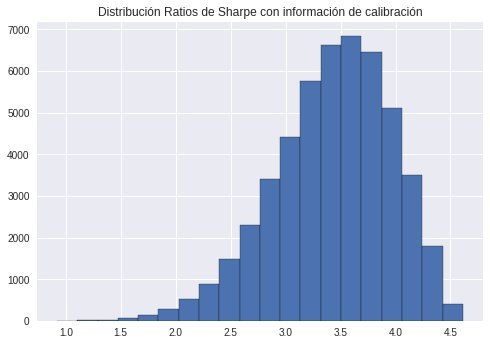

In [41]:
#Histogramas de ratios de Sharpe
plt.hist(resultados_combinaciones["Ratio de Sharpe"], bins=20, edgecolor='black')
plt.title("Distribución Ratios de Sharpe con información de calibración")
plt.show()



####**Distribución Ratios de Sharpe con información de testeo**

En comparación a la distribución anterior. Vemos que durante el periodo de testeo los retornos del mercado disminuyen e incluso entran en terreno negativo. Más adelante veremos como evolucionan los indices a lo largo del tiempo utilizado para entrenar, y a lo largo del tiempo de testeo

Dicha ayuda visual será más útil para conectar lo que muestran estos gráficos con lo que dice la evolución de los índices.

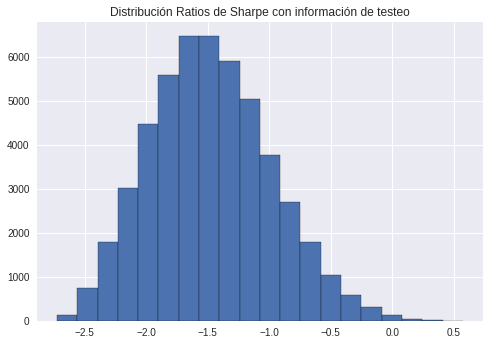

In [43]:
#Histogramas de ratios de Sharpe
portafolio_optimo(retornos_exceso1)
plt.hist(resultados_combinaciones["Ratio de Sharpe"], bins=20, edgecolor='black')
plt.title("Distribución Ratios de Sharpe con información de testeo")
plt.show()

####**Evolución de Índices a lo largo del tiempo utilizado para maximizar**
Grafiquemos los indices a lo largo del tiempo usado para maximizar. Para comprobar cualitativamente si nuestra intuición tiene algo de cierto.

Con este sencillo paso veremos que la mayoría de los índices (salvo por Bovespa) muestran prolongados "rallies" desde el 2010. Brasil tiene un rally desde el 2016. Esto "sesga" los pesos del portafolio. Especialmente si luego (en el periodo de "backtest") ocurre un "reversal" de los índices.

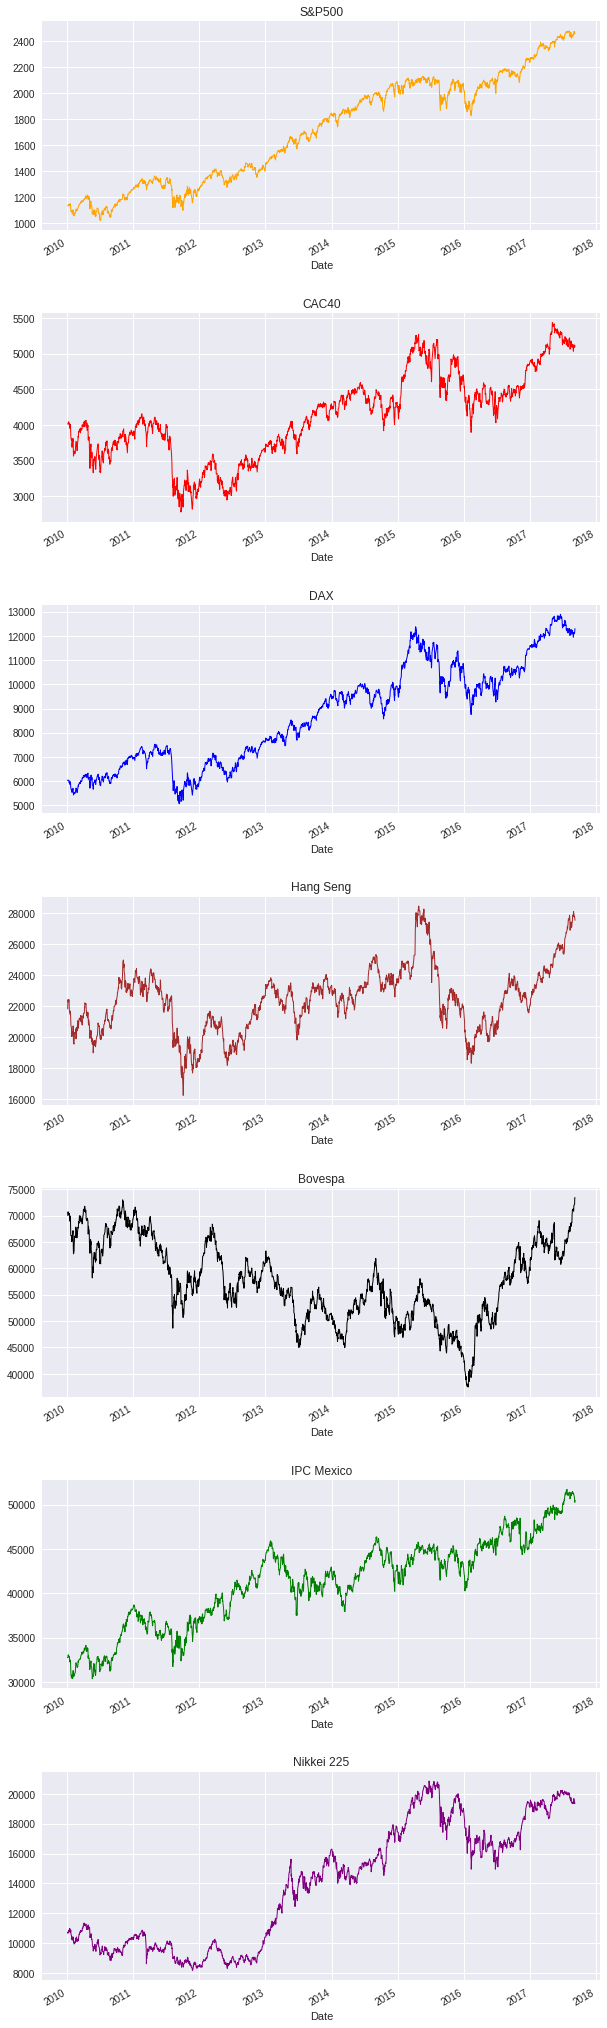

In [53]:
indices_calibracion = market_data.iloc[:2000,:]
fig = plt.figure(figsize=(10,40))
ax1 = fig.add_subplot(7, 1, 1)
indices_calibracion["^GSPC"].plot(c="orange", lw=1)
plt.title("S&P500")
ax2 = fig.add_subplot(7, 1, 2)
indices_calibracion["^FCHI"].plot(c="red", lw=1)
plt.title("CAC40")
ax3 = fig.add_subplot(7, 1, 3)
indices_calibracion["^GDAXI"].plot(c="blue", lw=1)
plt.title("DAX")
ax4 = fig.add_subplot(7, 1, 4)
indices_calibracion["^HSI"].plot(c="brown", lw=1)
plt.title("Hang Seng")
ax5 = fig.add_subplot(7, 1, 5)
indices_calibracion["^BVSP"].plot(c="black", lw=1)
plt.title("Bovespa")
ax6 = fig.add_subplot(7, 1, 6)
indices_calibracion["^MXX"].plot(c="green", lw=1)
plt.title("IPC Mexico")
ax7 = fig.add_subplot(7, 1, 7)
indices_calibracion["^N225"].plot(c="purple", lw=1)
plt.title("Nikkei 225")
plt.subplots_adjust(wspace=0.3, hspace=0.4)

####**Evolución de Índices a lo largo del tiempo utilizado para testear**

Vemos que la mayoría de los índices sufren pérdidas durante el año o a fines del año, menos Brasil y Japón, sin embargo, este último tiene dos peaks y termina el año habiendo perdido practicamente todo lo ganado durante el año.

Brasil continúa su rally gracias a mejores expectativas económicas por un presidente que el mercado ve positivamente.

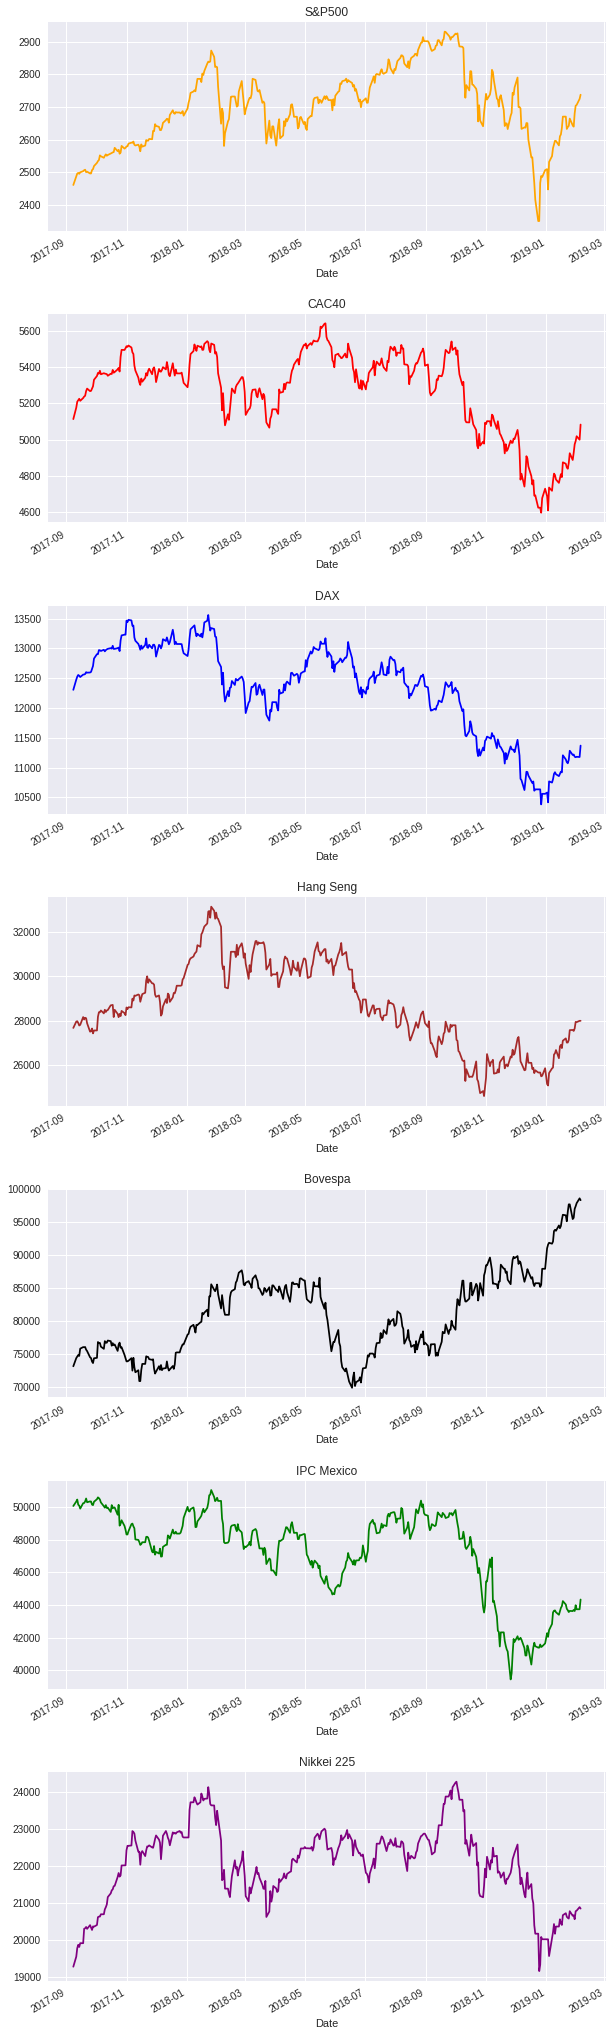

In [52]:
indices_testeo = market_data.iloc[2000:,:]
fig = plt.figure(figsize=(10,40))
ax1 = fig.add_subplot(7, 1, 1)
indices_testeo["^GSPC"].plot(c="orange")
plt.title("S&P500")
ax2 = fig.add_subplot(7, 1, 2)
indices_testeo["^FCHI"].plot(c="red")
plt.title("CAC40")
ax3 = fig.add_subplot(7, 1, 3)
indices_testeo["^GDAXI"].plot(c="blue")
plt.title("DAX")
ax4 = fig.add_subplot(7, 1, 4)
indices_testeo["^HSI"].plot(c="brown")
plt.title("Hang Seng")
ax5 = fig.add_subplot(7, 1, 5)
indices_testeo["^BVSP"].plot(c="black")
plt.title("Bovespa")
ax6 = fig.add_subplot(7, 1, 6)
indices_testeo["^MXX"].plot(c="green")
plt.title("IPC Mexico")
ax7 = fig.add_subplot(7, 1, 7)
indices_testeo["^N225"].plot(c="purple")
plt.title("Nikkei 225")
plt.subplots_adjust(wspace=0.3, hspace=0.4)

####**Investigamos los detalles de las posibles combinaciones**

El código a continuación nos podría servir para seleccionar algún portafolio que posea un retorno superior, pero más riesgoso. O bien buscar aquella combinación que minimice la volatilidad. 

Cualquier característica relacionada con la volatilidad, retornos, ratio de Sharpe, y pesos, este código lo recibe flexiblemente con una pequeños ajustes. Así el inversionista puede explorar aquella combinación que más le acomode o estime conveniente.

In [0]:
resultados_combinaciones_cola = resultados_combinaciones[resultados_combinaciones["Ratio de Sharpe"]>4.0]
resultados_combinaciones_cola.describe()

#vemos que ahora los pesos están más equitativamente distribuidos

,Ratio de Sharpe,Retornos,Volatilidad,^BVSP Peso,^FCHI Peso,^GDAXI Peso,^GSPC Peso,^HSI Peso,^MXX Peso,^N225 Peso
count,7124.000000,7124.000000,7124.000000,7124.000000,7124.000000,7124.000000,7124.000000,7124.000000,7124.000000,7124.000000
mean,4.185887,0.075317,0.017988,0.076142,0.120841,0.186962,0.191200,0.097695,0.130368,0.196791
std,0.134244,0.005423,0.001072,0.047622,0.062984,0.057015,0.058591,0.057404,0.063752,0.054988
min,4.000026,0.064631,0.016113,0.000005,0.000052,0.021434,0.029844,0.000072,0.000093,0.049707
25%,4.072807,0.071263,0.017183,0.035974,0.071084,0.148829,0.151261,0.050283,0.083232,0.160120
50%,4.160839,0.074588,0.017819,0.072431,0.121599,0.187110,0.190707,0.095711,0.133125,0.194333
75%,4.278659,0.078644,0.018607,0.111714,0.169632,0.224177,0.227451,0.141685,0.178090,0.231333
max,4.613281,0.098170,0.023061,0.210119,0.300714,0.416165,0.451127,0.258145,0.311800,0.454251


####**Conclusiones**

Este primer trabajo nos muestra que es muy importante utilizar información similar para "calibrar" y "testear" el portafolio óptimo de Markowitz.

**Las explicaciones económicas entregadas en este análisis son propias. Agradezco cualquier observación que mejore mis conclusiones en caso de ser necesaria una acotación.**